&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&ensp;
[Home Page](../../START_HERE.ipynb)

[Previous Notebook](Challenge.ipynb)
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
[1](Challenge.ipynb)
[2]

# Bike Rental Prediction Challenge- Workbook

## 1. Introduction

This notebook walks through an end-to-end GPU machine learning workflow where cuDF is used for processing the data and cuML is used to train machine learning models on it. 

After completing this excercise, you will be able to use cuDF to load data from disk, combine tables, scale features, use one-hote encoding and even write your own GPU kernels to efficiently transform feature columns. Additionaly you will learn how to pass this data to cuML, and how to train ML models on it. The trained model is saved and it will be used for prediction.

It is not required that the user is familiar with cuDF or cuML. Since our aim is to go from ETL to ML training, a detailed introduction is out of scope for this notebook. We recommend [Introduction to cuDF](../../CuDF/01-Intro_to_cuDF.ipynb)  for additional information.


### 1.2. Problem statement

We are trying to predict daily demand for short-term bike rentals made in 2011 and 2012. We will combine three data sources: bike rental information, historical weather data, and dates of public holidays. In Section 2 of this notebook we will use cuDF to combine these data into a single dataset that can be used as an input for machine learning algorithms.  In Section 3 we train models using cuML to predict bike rentals.

### 1.3 Why RAPIDS?

Using the GPU accelerated libraries from RAPIDS greatly reduces the execution time of a data science workflow. This leads to faster iteration with data preparation and model selection, and overall a more efficient workflow. 


### 1.2.1 References

This notebook is inspired by the [blog article](https://medium.com/rapids-ai/essential-machine-learning-with-linear-models-in-rapids-part-1-of-a-series-992fab0240da) from Paul Mahler and its accompanying [notebook](https://github.com/rapidsai-community/notebooks-contrib/blob/master/blog_notebooks/regression/regression_blog_notebook.ipynb). The dataset is prepared along the steps given by *Hadi Fanaee-T and Joao Gama* in their [paper](https://doi.org/10.1007/s13748-013-0040-3) *Event labeling combining ensemble detectors and background knowledge*. The exploratory data analysis notebooks by [Vivek Srinivasan](https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile) and [Mitesh Yadav](https://www.kaggle.com/miteshyadav/comprehensive-eda-with-xgboost-top-10-percentile) provided useful input for this excercise. 

First part of this notebook contains sections from [Introduction to cuDF](https://github.com/rapidsai-community/notebooks-contrib/blob/master/getting_started_notebooks/intro_tutorials/02_Introduction_to_cuDF.ipynb) by Paul Hendricks, which gives a concise introduction to cuDF, also discussing a few points  not mentioned in this notebook. 

Dataset sources:
- The bike sharing dataset is provided by [Capital Bike Share](https://www.capitalbikeshare.com/system-data).
- The weather data is retrieved from the [Bike Sharing Dataset](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset) hosted by the UCI Machine Learning repository.
- The original source of the weather data is https://www.freemeteo.com.



<!--Two more introductory notebooks with excercises is presented by Zahra Ronaghi 
[Into to cuDF](https://github.com/zronaghi/nasa-ml-workshop/blob/master/cudf/01-Intro_to_cuDF.ipynb) and
[Intro to cuML](https://github.com/zronaghi/nasa-ml-workshop/blob/master/cuml/01-LinearRegression-Hyperparam.ipynb).
-->





## 2. Prepare dataset with cuDF
Let's start by loading the necessary libraries

In [1]:
import cudf
import pandas as pd
import numpy as np

from datetime import datetime, timedelta
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
import importlib
import utils
importlib.reload(utils)
from utils import fetch_bike_dataset, fetch_weather_dataset, read_bike_data_pandas
import matplotlib.pyplot as plt
import seaborn as sns

### 2.1 Prepare weather data
First, we will download the weather data.

In [2]:
filename = fetch_weather_dataset()

Weather file saved at  data/weather2011-2012.csv


cuDF DataFrames are a tabular structure of data that reside on the GPU. We interface with these cuDF DataFrames in the same way we interface with Pandas DataFrames that reside on the CPU - with a few deviations. Load data from CSV file into a cuDF DataFrame.

In [3]:
weather = cudf.read_csv(filename)

#### 2.1.1 Inspecting a cuDF DataFrame

There are several ways to inspect a cuDF DataFrame. The first method is to enter the cuDF DataFrame directly into the REPL. This shows us an overview about the DatFrame including its type and metadata such as the number of rows or columns.

In [4]:
weather

,Hour,Temperature,Relative Temperature,Rel. humidity,Wind,Weather
0,2011-01-01T00:00:00Z,3.28,3.0014,81,0.0000,Clear or Partly cloudy
1,2011-01-01T01:00:00Z,2.34,1.9982,80,0.0000,Clear or Partly cloudy
2,2011-01-01T02:00:00Z,2.34,1.9982,80,0.0000,Clear or Partly cloudy
3,2011-01-01T03:00:00Z,3.28,3.0014,75,0.0000,Clear or Partly cloudy
4,2011-01-01T04:00:00Z,3.28,3.0014,75,0.0000,Clear or Partly cloudy
...,...,...,...,...,...,...
17374,2012-12-31T19:00:00Z,4.22,1.0016,60,11.0014,Mist or Cloudy
17375,2012-12-31T20:00:00Z,4.22,1.0016,60,11.0014,Mist or Cloudy
17376,2012-12-31T21:00:00Z,4.22,1.0016,60,11.0014,Clear or Partly cloudy
17377,2012-12-31T22:00:00Z,4.22,1.9982,56,8.9981,Clear or Partly cloudy


A second way to inspect a cuDF DataFrame is to wrap the object in a Python print function `print(weather)` function. This results in showing the rows and columns of the dataframe with simple formating.

For very large dataframes, we often want to see the first couple rows. We can use the `head` method of a cuDF DataFrame to view the first N rows.

In [5]:
weather.head(3)

,Hour,Temperature,Relative Temperature,Rel. humidity,Wind,Weather
0,2011-01-01T00:00:00Z,3.28,3.0014,81,0.0,Clear or Partly cloudy
1,2011-01-01T01:00:00Z,2.34,1.9982,80,0.0,Clear or Partly cloudy
2,2011-01-01T02:00:00Z,2.34,1.9982,80,0.0,Clear or Partly cloudy


#### 2.1.2 Columns

cuDF DataFrames store metadata such as information about columns or data types. We can access the columns of a cuDF DataFrame using the `.columns` attribute.

In [6]:
print(weather.columns)

Index(['Hour', 'Temperature', 'Relative Temperature', 'Rel. humidity', 'Wind',
       'Weather'],
      dtype='object')


We can modify the columns of a cuDF DataFrame by modifying the `columns` attribute. We can do this by setting that attribute equal to a list of strings representing the new columns. Let's shorten the two longest column names!

In [7]:
### TODO rename the relative temperature column to RTemp, and the relative humidity to Humidity
#weather.columns = ['Hour', 'Temperature', 'Relative Temperature', 'Rel. Humidity', 'Wind', 'Weather']
weather.columns = ['Hour', 'Temperature', 'RTemp', 'Humidity', 'Wind', 'Weather']
weather.head()

,Hour,Temperature,RTemp,Humidity,Wind,Weather
0,2011-01-01T00:00:00Z,3.28,3.0014,81,0.0,Clear or Partly cloudy
1,2011-01-01T01:00:00Z,2.34,1.9982,80,0.0,Clear or Partly cloudy
2,2011-01-01T02:00:00Z,2.34,1.9982,80,0.0,Clear or Partly cloudy
3,2011-01-01T03:00:00Z,3.28,3.0014,75,0.0,Clear or Partly cloudy
4,2011-01-01T04:00:00Z,3.28,3.0014,75,0.0,Clear or Partly cloudy


#### 2.1.3 Series

cuDF DataFrames are composed of rows and columns. Each column is represented using an object of type `Series`. For example, if we subset a cuDF DataFrame using just one column we will be returned an object of type `cudf.dataframe.series.Series`.

In [8]:
humidity = weather['Humidity']
print(type(humidity))
print(humidity)

<class 'cudf.core.series.Series'>
0        81
1        80
2        80
3        75
4        75
         ..
17374    60
17375    60
17376    60
17377    56
17378    65
Name: Humidity, Length: 17379, dtype: int64


We also see a column of values on the left hand side with values 0, 1, 2, 3. These values represent the index of the Series.
The DataFrame and Series objects have both an index attribute that will be useful for joining tables and also for selecting data.

#### 2.1.4 Data Types

We can also inspect the data types of the columns of a cuDF DataFrame using the `dtypes` attribute.

In [9]:
print(weather.dtypes)

Hour            object
Temperature    float64
RTemp          float64
Humidity         int64
Wind           float64
Weather         object
dtype: object


We can modify the data types of the columns of a cuDF DataFrame by passing in a cuDF Series with a modified data type.

In [10]:
weather['Humidity'] = weather['Humidity'].astype(np.float64)
print(weather.dtypes)

Hour            object
Temperature    float64
RTemp          float64
Humidity       float64
Wind           float64
Weather         object
dtype: object


The 'Weather' column provides a description of the weather condidions. We should mark it as a categorical column.

In [11]:
weather['Weather'] = weather['Weather'].astype('category')
weather['Weather']

0        Clear or Partly cloudy
1        Clear or Partly cloudy
2        Clear or Partly cloudy
3        Clear or Partly cloudy
4        Clear or Partly cloudy
                  ...          
17374            Mist or Cloudy
17375            Mist or Cloudy
17376    Clear or Partly cloudy
17377    Clear or Partly cloudy
17378    Clear or Partly cloudy
Name: Weather, Length: 17379, dtype: category
Categories (4, object): ['Clear or Partly cloudy', 'Heavy Rain, Snow + Fog, Ice', 'Light Rain or Snow, Thunderstorm', 'Mist or Cloudy']

After this step the numerical category codes can be accessed using the `.cat.codes` attribute of the column. We actually will not need the category labels, we just replace the 'Weather' column with the category codes.

In [12]:
weather['Weather'] = weather['Weather'].cat.codes

The data type of the 'Hour' column is `object` which means a string. Let's convert this to a numeric value! This cannot be done with the `astype` method, you should use the [cudf.to_datetime](https://docs.rapids.ai/api/cudf/nightly/api.html#cudf.to_datetime) function!

In [13]:
### TODO convert the 'Hour' column from string to datetime
weather['Hour'] = cudf.to_datetime(weather['Hour'])
weather.dtypes

Hour           datetime64[ns]
Temperature           float64
RTemp                 float64
Humidity              float64
Wind                  float64
Weather                 uint8
dtype: object

#### 2.1.2 Prepare features
##### Operations with cudf Series
We can perform mathematical operations on the Series data type. We will scale the Humidity and and Temperature variables, so that they lay in the [0, 1] range (some ML algorithms work better if the input data is scaled this way).

In [14]:
weather['Humidity'] = weather['Humidity'] / 100.0

We will scale the temperature using the following formula T = (T - Tmin) / (Tmax - Tmin). First we select the min and max values.

In [15]:
T = weather['Temperature']

# Select the minimum temperature
Tmin = T.min()

### TODO select the maximum temperature (1 line of code)
Tmax = T.max()

print(Tmin, Tmax)

-7.06 39.0


We could simply use the Tmin and Tmax values and apply the above formula on the series. 

##### User defined functions (UDF)
We can write custom functions to operate on the data. When cuDF executes a UDF, it gets just-in-time (JIT) compiled into a CUDA kernel (either explicitly or implicitly) and is run on the GPU. Let's write a function that scales the temperature!

In [16]:
def scale_temp(T):
    # Note that the Tmin and Tmax variables are stored during compilation time and remain constant afterwards
    T = (T - Tmin) / (Tmax - Tmin)
    return T 

The applymap function will call scale_temp on all element of the series

In [17]:
weather['Temperature'] = weather['Temperature'].applymap(scale_temp)

Lets do the same min-max scaling for the wind data

In [18]:
### TODO calculate the minimum and maximum values of the 'Wind' column (2 lines of code)
Wmin = weather['Wind'].min()
Wmax = weather['Wind'].max()

print(Wmin, Wmax)

### TODO define a scale_wind function and apply it on the Wind column (~ 2-3 lines of code)
def scale_wind(w):
    return (w - Wmin) / ( Wmax  - Wmin)

### TODO apply the scale_wind function on the 'Wind' column
weather['Wind'] = weather['Wind'].applymap(scale_wind)

0.0 56.996900000000004


Let's inspect the table, the Temperature, Wind and Humidity columns should have values in the [0, 1] range.

In [19]:
weather.describe()

,Temperature,RTemp,Humidity,Wind,Weather
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.486722,15.401157,0.626947,0.223460,0.947868
std,0.196486,11.342114,0.193013,0.143811,1.334769
min,0.000000,-16.000000,0.000000,0.000000,0.000000
25%,0.326531,5.997800,0.480000,0.122840,0.000000
50%,0.489796,15.996800,0.630000,0.228047,0.000000
75%,0.653061,24.999200,0.780000,0.298225,3.000000
max,1.000000,50.000000,1.000000,1.000000,3.000000


##### Dropping Columns

The relative temperature column is correlated with the temperature, it will not give much extra information for the ML model. We want to remove this column from our `DataFrame`. We can do so using the `drop_column` method. Note that this method removes a column in-place - meaning that the `DataFrame` we act on will be modified.

In [20]:
weather.drop_column('RTemp')
weather

,Hour,Temperature,Humidity,Wind,Weather
0,2011-01-01 00:00:00,0.224490,0.81,0.000000,0
1,2011-01-01 01:00:00,0.204082,0.80,0.000000,0
2,2011-01-01 02:00:00,0.204082,0.80,0.000000,0
3,2011-01-01 03:00:00,0.224490,0.75,0.000000,0
4,2011-01-01 04:00:00,0.224490,0.75,0.000000,0
...,...,...,...,...,...
17374,2012-12-31 19:00:00,0.244898,0.60,0.193018,3
17375,2012-12-31 20:00:00,0.244898,0.60,0.193018,3
17376,2012-12-31 21:00:00,0.244898,0.60,0.193018,0
17377,2012-12-31 22:00:00,0.244898,0.56,0.157870,0


If we want to remove a column without modifying the original DataFrame, we can use the `drop` method. This method will return a new DataFrame without that column (or columns).

##### Index

Like `Series` objects, each `DataFrame` has an index attribute.

In [21]:
weather.index

RangeIndex(start=0, stop=17379)

We can use the index values to subset the `DataFrame`. Lets use this to plot the first 48 values. Before plotting we have to transfer from the GPU memory to the system memory. We use the `to_array` method to return a copy of the data as a numpy array.

Text(0, 0.5, 'Temperature [C]')

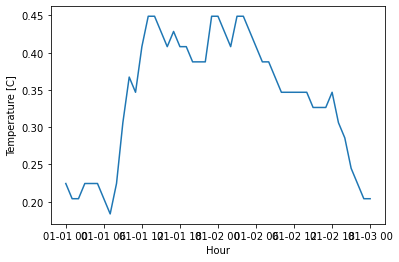

In [22]:
selection = weather[weather.index<48]
plt.plot(selection['Hour'].to_array(), selection['Temperature'].to_array())
plt.xlabel('Hour')
plt.ylabel('Temperature [C]')

We can also change the index. Our dataset has one entry for each hour, so one could set the 'Hour' coulmn as index by calling
```
weather = weather.set_index('Hour')
```

We do not perform this change right now, but we will use it later.

In [23]:
#weather = weather.set_index('Hour')

### 2.2 Prepare bike sharing data
We start by downloading the data

In [24]:
files = fetch_bike_dataset([2011,2012])

24744.0kB [00:01, 13625.36kB/s]                                  
42448.0kB [00:17, 2456.30kB/s]                                      


Files extracted: ['data/2011-capitalbikeshare-tripdata.csv', 'data/2012Q1-capitalbikeshare-tripdata.csv', 'data/2012Q2-capitalbikeshare-tripdata.csv', 'data/2012Q3-capitalbikeshare-tripdata.csv', 'data/2012Q4-capitalbikeshare-tripdata.csv']


Let's read the first file to have an idea of the dataset

In [25]:
cudf.read_csv(files[0])

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,3548,2011-01-01 00:01:29,2011-01-01 01:00:37,31620,5th & F St NW,31620,5th & F St NW,W00247,Member
1,346,2011-01-01 00:02:46,2011-01-01 00:08:32,31105,14th & Harvard St NW,31101,14th & V St NW,W00675,Casual
2,562,2011-01-01 00:06:13,2011-01-01 00:15:36,31400,Georgia & New Hampshire Ave NW,31104,Adams Mill & Columbia Rd NW,W00357,Member
3,434,2011-01-01 00:09:21,2011-01-01 00:16:36,31111,10th & U St NW,31503,Florida Ave & R St NW,W00970,Member
4,233,2011-01-01 00:28:26,2011-01-01 00:32:19,31104,Adams Mill & Columbia Rd NW,31106,Calvert & Biltmore St NW,W00346,Casual
...,...,...,...,...,...,...,...,...,...
1226762,300,2011-12-31 23:41:19,2011-12-31 23:46:20,31201,15th & P St NW,31214,17th & Corcoran St NW,W01459,Member
1226763,387,2011-12-31 23:46:43,2011-12-31 23:53:10,31223,Convention Center / 7th & M St NW,31201,15th & P St NW,W01262,Member
1226764,261,2011-12-31 23:47:27,2011-12-31 23:51:49,31107,Lamont & Mt Pleasant NW,31602,Park Rd & Holmead Pl NW,W00998,Member
1226765,2060,2011-12-31 23:55:12,2012-01-01 00:29:33,31205,21st & I St NW,31222,New York Ave & 15th St NW,W00042,Member


We are only interested in the events when a bicicle was rented. Let us read the first column from all files, by specifying the `usecols` argument to [read_csv](https://docs.rapids.ai/api/cudf/nightly/api.html#cudf.io.csv.read_csv). We can use the `parse_dates` argument to parse the date string into a datetime variable, or the [to_datetime](https://docs.rapids.ai/api/cudf/nightly/api.html#cudf.to_datetime) function that we have used for the weather dataset. After all the tables are read we will concatenate them.

Note: one has to specify a list of columns [ column1, column2 ] for the `usecol` argument.

In [26]:
def read_bike_data(files):
    # Reads a list of files and concatenates them
    tables = []
    for filename in files:
        ### TODO read column 1 ('Start date') from the CSV file, and convert it to datetime format
        ### (1-2 lines of code)
        tmp_df = cudf.read_csv(filename, parse_dates=[1], usecols=[1])
        
        ### END TODO
        tables.append(tmp_df) 
        
    merged_df = cudf.concat(tables, ignore_index=True)
    
    # Sanity checks
    if merged_df.columns != ['Start date']:
        raise ValueError("Error incorrect set of columns read")
    if merged_df['Start date'].dtype != 'datetime64[ns]':
        raise TypeError("Stard date should be converted to datetime type")
        
    return merged_df

We will also measure the execution time of reading and processing the data (you can execute the cell multiple times to have a better measurement).

In [27]:
%%time
bikes_raw = read_bike_data(files)

CPU times: user 91.6 ms, sys: 330 ms, total: 422 ms
Wall time: 421 ms


For comparision, we can repeat the same operation on the CPU. We have prepared a helper function for that.

In [28]:
%%time
bikes_raw_pd = read_bike_data_pandas(files)

CPU times: user 4.31 s, sys: 192 ms, total: 4.51 s
Wall time: 4.5 s


We want to count the number of rental events in every hour. We will define a new feature where we remove the minutes and seconds part of the time stamp. Since pandas has a convenient `floor` function defined to do it, we will convert the column to a pandas Series, transform it with the floor operation, and then put it back on the GPU.

In [29]:
bikes_raw['Hour'] = bikes_raw['Start date'].to_pandas().dt.floor('h')

We will aggregate the number of bicicle rental events for each hour. We use the [groupby](https://docs.rapids.ai/api/cudf/nightly/api.html#groupby) function.

In [30]:
bikes = bikes_raw.groupby('Hour').agg('count')
bikes.columns = ['cnt']
bikes.head(5)

,cnt
Hour,
2011-01-01 00:00:00,16
2011-01-01 01:00:00,38
2011-01-01 02:00:00,31
2011-01-01 03:00:00,12
2011-01-01 04:00:00,1


Let's add a column to the new dataset: the date without the time of the day. We can derive that similarly to the 'Hour' feature above. After the groupby operation, the 'Hour' became the index of the dataset, we will apply the `floor` operation on the index. 

In [31]:
bikes['date'] = bikes.index.to_pandas().floor('D')

It will be usefull to define a set of additional features: hour of the day, day of month, month and year https://docs.rapids.ai/api/cudf/nightly/api.html#datetimeindex

In [32]:
bikes['hr'] = bikes.index.hour

### TODO add year and month features (~ 2 lines of code)
bikes['year'] = bikes.index.year
bikes['month'] = bikes.index.month

Remove the offset from year

In [33]:
bikes['year'] = bikes['year'] - 2011

#### Visualize data
It is a good practice to visulize the data. We will have to use the to_array() method to convert the cudF Series objects to numpy arrays that can be plotted.

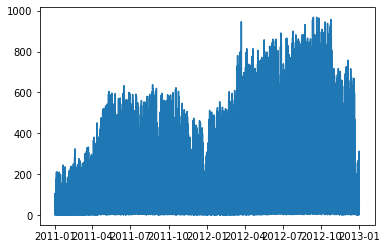

In [34]:
plt.plot(bikes.index.to_array(), bikes['cnt'].to_array())

It is hard to see much apart from the global trend. Let's have a look how the 'cnt' variable looks like as a function the 'month' and 'hr' features. We will use [boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html) from the Seaborn package.

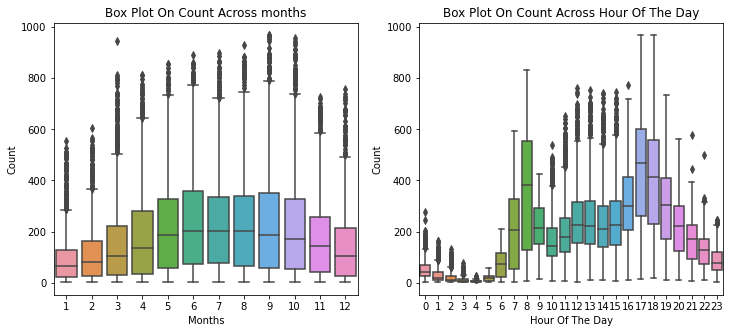

In [35]:
fig, axes = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(12, 5)
sns.boxplot(data=bikes.to_pandas(), y="cnt",x="month",orient="v",ax=axes[0])
sns.boxplot(data=bikes.to_pandas(), y="cnt",x="hr",orient="v",ax=axes[1])
axes[0].set(xlabel='Months', ylabel='Count',title="Box Plot On Count Across months")
axes[1].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
plt.show()

#### 3.2.1 Combine weather data with bike rental data

In [36]:
gdf_bw = bikes.merge(weather, left_index=True, right_on='Hour', how='inner')

# inspect the merged table
gdf_bw

,cnt,date,hr,year,month,Hour,Temperature,Humidity,Wind,Weather
17376,90,2012-12-31,21,1,12,2012-12-31 21:00:00,0.244898,0.60,0.193018,0
17377,61,2012-12-31,22,1,12,2012-12-31 22:00:00,0.244898,0.56,0.157870,0
17378,50,2012-12-31,23,1,12,2012-12-31 23:00:00,0.244898,0.65,0.157870,0
5184,146,2011-08-08,22,0,8,2011-08-08 22:00:00,0.755102,0.57,0.122840,0
5185,72,2011-08-08,23,0,8,2011-08-08 23:00:00,0.734694,0.66,0.122840,0
...,...,...,...,...,...,...,...,...,...,...
2331,13,2011-04-12,1,0,4,2011-04-12 01:00:00,0.612245,0.50,0.105325,3
2332,14,2011-04-12,2,0,4,2011-04-12 02:00:00,0.591837,0.53,0.157870,3
2333,1,2011-04-12,3,0,4,2011-04-12 03:00:00,0.571429,0.56,0.157870,3
2334,6,2011-04-12,4,0,4,2011-04-12 04:00:00,0.551020,0.64,0.157870,3


We can see that the data is not sorted after the merge use the [sort_values](https://docs.rapids.ai/api/cudf/nightly/api.html#cudf.core.dataframe.DataFrame.sort_values) method to

In [37]:
### TODO sort the table according to the index (1 line of code)
gdf_bw = gdf_bw.sort_values(by='Hour')

# Inspect the sorted table
gdf_bw

,cnt,date,hr,year,month,Hour,Temperature,Humidity,Wind,Weather
0,16,2011-01-01,0,0,1,2011-01-01 00:00:00,0.224490,0.81,0.000000,0
1,38,2011-01-01,1,0,1,2011-01-01 01:00:00,0.204082,0.80,0.000000,0
2,31,2011-01-01,2,0,1,2011-01-01 02:00:00,0.204082,0.80,0.000000,0
3,12,2011-01-01,3,0,1,2011-01-01 03:00:00,0.224490,0.75,0.000000,0
4,1,2011-01-01,4,0,1,2011-01-01 04:00:00,0.224490,0.75,0.000000,0
...,...,...,...,...,...,...,...,...,...,...
17374,118,2012-12-31,19,1,12,2012-12-31 19:00:00,0.244898,0.60,0.193018,3
17375,89,2012-12-31,20,1,12,2012-12-31 20:00:00,0.244898,0.60,0.193018,3
17376,90,2012-12-31,21,1,12,2012-12-31 21:00:00,0.244898,0.60,0.193018,0
17377,61,2012-12-31,22,1,12,2012-12-31 22:00:00,0.244898,0.56,0.157870,0


### 3.3 Add working day feature

Apart from the weather, in important factor that influences people's daily activities is whether it is a working day or not. In this section we will create a working day feature. First we add the weekday as a new feature column. 
We can use the [weekday](https://docs.rapids.ai/api/cudf/nightly/api.html#cudf.core.series.DatetimeProperties.weekday) attribute of the [datetime](https://docs.rapids.ai/api/cudf/nightly/api.html#datetimeindex)

In [38]:
gdf_bw['Weekday'] = gdf_bw['date'].dt.weekday

Next create a table with all the holidays in Washington DC in 2011-2011

In [39]:
holidays = cudf.DataFrame({'date': ['2011-01-17', '2011-02-21', '2011-04-15', '2011-05-30', '2011-07-04', '2011-09-05', '2011-11-11', '2011-11-24', '2011-12-26', '2012-01-02', '2012-01-16', '2012-02-20', '2012-04-16', '2012-05-28', '2012-07-04', '2012-09-03', '2012-11-12', '2012-11-22', '2012-12-25'],
'Description': ["Martin Luther King Jr. Day", "Washington's Birthday", "Emancipation Day", "Memorial Day", "Independence Day", "Labor Day", "Veterans Day", "Thanksgiving", "Christmas Day", 
"New Year's Day", "Martin Luther King Jr. Day", "Washington's Birthday", "Emancipation Day", "Memorial Day", "Independence Day", "Labor Day", "Veterans Day", "Thanksgiving", "Christmas Day"]})

# Print the dataframe
holidays

,date,Description
0,2011-01-17,Martin Luther King Jr. Day
1,2011-02-21,Washington's Birthday
2,2011-04-15,Emancipation Day
3,2011-05-30,Memorial Day
4,2011-07-04,Independence Day
5,2011-09-05,Labor Day
6,2011-11-11,Veterans Day
7,2011-11-24,Thanksgiving
8,2011-12-26,Christmas Day
9,2012-01-02,New Year's Day


We convert the date from string to datetime type, and drop the description column. Additionally we add a new column marked 'Holiday'. This will be useful to mark the holidays after we merge the tables.

In [40]:
holidays['date'] = cudf.to_datetime(holidays['date'])
holidays.drop_column('Description')
holidays['Holiday'] = 1
holidays

,date,Holiday
0,2011-01-17,1
1,2011-02-21,1
2,2011-04-15,1
3,2011-05-30,1
4,2011-07-04,1
5,2011-09-05,1
6,2011-11-11,1
7,2011-11-24,1
8,2011-12-26,1
9,2012-01-02,1


Now we are ready to merge the tables using the commond `date` column. We want keep every element from the gdf_bw table (our *left* table), so we use a left join. Hint: use [merge](https://docs.rapids.ai/api/cudf/nightly/api.html#cudf.core.dataframe.DataFrame.merge) with the `on` and `how` attributes

In [41]:
### TODO merge tables and on the column 'date', use a left merge 
gdf = gdf_bw.merge(holidays, on='date', how='left')

# inspect the result
gdf

,cnt,date,hr,year,month,Hour,Temperature,Humidity,Wind,Weather,Weekday,Holiday
0,297,2011-12-03,16,0,12,2011-12-03 16:00:00,0.367347,0.46,0.000000,0,5,<NA>
1,229,2011-12-03,17,0,12,2011-12-03 17:00:00,0.346939,0.62,0.000000,0,5,<NA>
2,220,2011-12-03,18,0,12,2011-12-03 18:00:00,0.326531,0.53,0.157870,0,5,<NA>
3,174,2011-12-03,19,0,12,2011-12-03 19:00:00,0.285714,0.61,0.105325,0,5,<NA>
4,124,2011-12-03,20,0,12,2011-12-03 20:00:00,0.285714,0.61,0.105325,0,5,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,15,2011-12-25,19,0,12,2011-12-25 19:00:00,0.306122,0.56,0.157870,0,6,<NA>
17374,25,2011-12-25,20,0,12,2011-12-25 20:00:00,0.306122,0.49,0.105325,0,6,<NA>
17375,18,2011-12-25,21,0,12,2011-12-25 21:00:00,0.285714,0.56,0.157870,0,6,<NA>
17376,17,2011-12-25,22,0,12,2011-12-25 22:00:00,0.265306,0.61,0.193018,0,6,<NA>


We reset the index to 'Hour' and sort the table accordingly. Notice that most of the rows in the 'Holiday' column are filled with `<NA>`, only the dates that appeared in the holiday table are filled with 1. We shall fill the empty fields with zero.

In [42]:
gdf = gdf.set_index('Hour')
gdf = gdf.sort_index()

### TODO fill empty holiday values with zero
gdf['Holiday'] = gdf['Holiday'].fillna(0)
gdf

,cnt,date,hr,year,month,Temperature,Humidity,Wind,Weather,Weekday,Holiday
Hour,,,,,,,,,,,
2011-01-01 00:00:00,16,2011-01-01,0,0,1,0.224490,0.81,0.000000,0,5,0
2011-01-01 01:00:00,38,2011-01-01,1,0,1,0.204082,0.80,0.000000,0,5,0
2011-01-01 02:00:00,31,2011-01-01,2,0,1,0.204082,0.80,0.000000,0,5,0
2011-01-01 03:00:00,12,2011-01-01,3,0,1,0.224490,0.75,0.000000,0,5,0
2011-01-01 04:00:00,1,2011-01-01,4,0,1,0.224490,0.75,0.000000,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,118,2012-12-31,19,1,12,0.244898,0.60,0.193018,3,0,0
2012-12-31 20:00:00,89,2012-12-31,20,1,12,0.244898,0.60,0.193018,3,0,0
2012-12-31 21:00:00,90,2012-12-31,21,1,12,0.244898,0.60,0.193018,0,0,0


Next, we create a workingday feature. Assuming that the first five days of the week are working days, one could do that simply with the following operation:
```
gdf['Workingday'] = (gdf['Weekday'] < 5) & (gdf['Holiday']!=1)
```
But we could do it with user defined functions too. Previously we have only used UDF to process elements of a series. Now we will process rows of a dataframe and
combine the 'Weekday' and 'Holiday' columns to calculate the new feature 'Workingday'.

More on user defined functions in our [blog](https://medium.com/rapids-ai/user-defined-functions-in-rapids-cudf-2d7c3fc2728d) and in the [documentation](https://docs.rapids.ai/api/cudf/nightly/guide-to-udfs.html).

In [43]:
def workday_kernel(Weekday, Holiday, Workingday):
    for i, (w, h) in enumerate(zip(Weekday, Holiday)):
        # variable w will take values from the Weekday column
        # variable h will take values from the Holiday column
        Workingday[i] = w < 5 and h != 1

In [44]:
gdf = gdf.apply_rows(workday_kernel, incols=['Weekday', 'Holiday'], outcols=dict(Workingday=np.float64), kwargs=dict())

After this step we will not need the 'Holiday' and 'date' columns, we can drop them

In [45]:
gdf = gdf.drop(['Holiday', 'date'])

### 2.4 One-hot encoding

We have all now the data in a single table, but we still want to change their encoding. We're going to create one-hot encoded variables, also known as dummy variables, for each of the time variables as well as the weather situation.


A summary from https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/:

"The integer values have a natural ordered relationship between each other and machine learning algorithms may be able to understand and harness this relationship.
For categorical variables where no such ordinal relationship exists, the integer encoding is not enough.

In fact, using this encoding and allowing the model to assume a natural ordering between categories may result in poor performance or unexpected results (predictions halfway between categories).

In this case, a one-hot encoding can be applied to the integer representation. This is where the integer encoded variable is removed and a new binary variable is added for each unique integer value.
"

We start by one-hot encoding the 'Weather' column using the [one_hot_encoding](https://docs.rapids.ai/api/cudf/nightly/api.html#cudf.core.dataframe.DataFrame.one_hot_encoding) method from cuDF DataFrame. This is very the [get_dummies](https://docs.rapids.ai/api/cudf/nightly/api.html#cudf.core.reshape.get_dummies) function (which might be more familiar for Pandas users), but one_hot_encoding works on a single input column and performs the operation in place. 

In [46]:
codes = gdf['Weather'].unique()
gdf = gdf.one_hot_encoding('Weather', 'Weather_dummy', codes)
# Inspect the results
gdf.head(3)

,cnt,hr,year,month,Temperature,Humidity,Wind,Weather,Weekday,Workingday,Weather_dummy_0,Weather_dummy_1,Weather_dummy_2,Weather_dummy_3
Hour,,,,,,,,,,,,,,
2011-01-01 00:00:00,16,0,0,1,0.224490,0.81,0.0,0,5,0.0,1.0,0.0,0.0,0.0
2011-01-01 01:00:00,38,1,0,1,0.204082,0.80,0.0,0,5,0.0,1.0,0.0,0.0,0.0
2011-01-01 02:00:00,31,2,0,1,0.204082,0.80,0.0,0,5,0.0,1.0,0.0,0.0,0.0


We're going to drop the original variable as well as one of the new dummy variables so we don't create colinearity (more about this problem [here](https://towardsdatascience.com/one-hot-encoding-multicollinearity-and-the-dummy-variable-trap-b5840be3c41a)).

In [47]:
gdf = gdf.drop(['Weather', 'Weather_dummy_1'])

We create a copy of the dataset. It will make it easier to start over in case something would go wrong during the next excercise. 

In [48]:
gdf_backup = gdf.copy()

In [49]:
dummies_list = ['month', 'hr', 'Weekday']

gdf = gdf_backup.copy()

for item in dummies_list:
    ### Todo implement one-hot encoding for item
    codes = gdf[item].unique()
    gdf = gdf.one_hot_encoding(item, item + '_dummy', codes)
    gdf = gdf.drop('{}_dummy_1'.format(item))
    gdf = gdf.drop(item) # drop the original item

In [50]:
gdf

,cnt,year,Temperature,Humidity,Wind,Workingday,Weather_dummy_0,Weather_dummy_2,Weather_dummy_3,month_dummy_2,...,hr_dummy_20,hr_dummy_21,hr_dummy_22,hr_dummy_23,Weekday_dummy_0,Weekday_dummy_2,Weekday_dummy_3,Weekday_dummy_4,Weekday_dummy_5,Weekday_dummy_6
Hour,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,16,0,0.224490,0.81,0.000000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011-01-01 01:00:00,38,0,0.204082,0.80,0.000000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011-01-01 02:00:00,31,0,0.204082,0.80,0.000000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011-01-01 03:00:00,12,0,0.224490,0.75,0.000000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011-01-01 04:00:00,1,0,0.224490,0.75,0.000000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,118,1,0.244898,0.60,0.193018,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-12-31 20:00:00,89,1,0.244898,0.60,0.193018,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-12-31 21:00:00,90,1,0.244898,0.60,0.193018,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### 2.5 Save the prepared dataset

In [51]:
gdf.to_csv('data/bike_sharing.csv')

## 3. Predict bike rentals with cuML

cuML is a GPU accelerated machine learning library. cuML's Python API mirrors the [Scikit-Learn](https://scikit-learn.org/stable/) API.

cuML currently requires all data be of the same type, so this loop converts all values into floats

In [52]:
import cuml

In [53]:
for col in gdf.columns:
    gdf[col] = gdf[col].astype('float64')

### 3.1 Prepare training and test data
It is customary to denote the input feature matrix with X, and the target that we want to predict with y. We separete the target column 'cnt' from the rest of the table.

In [54]:
y = gdf['cnt']
X = gdf.drop('cnt')

Let's split the data randomly into a train and a test set

In [55]:
X_train, X_test, y_train, y_test = cuml.preprocessing.model_selection.train_test_split(X, y)

### 3.2 Linear regression
Our first model is a simple linear regression, which tries to predict the output as a linear combination of the input features:

<img src="../img/regression_eq.png" width="150px">



In [56]:
reg = cuml.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(algorithm='eig', fit_intercept=True, normalize=False, handle=<cuml.common.handle.Handle object at 0x7f750b9b6830>, verbose=4, output_type='cudf')

We can make prediction with the trained data

In [57]:
y_hat = reg.predict(X_test)

We can visualize the how well the model works. Let's plot data for may 2012:

In [58]:
import datetime as dt
def plot_timerange(model, start, end):
    start_date = dt.datetime.strptime(start, '%Y-%m-%d')
    end_date = dt.datetime.strptime(end, '%Y-%m-%d')
    idx = (X.index >= start_date) & (X.index <= end_date)
    X_may = X[idx]
    y_may = y[idx]

    ### TODO predict the values for X_may (1 line of code)
    y_pred = reg.predict(X_may)

    plt.plot(X_may.index.to_array(), y_may.to_array())
    plt.plot(X_may.index.to_array(), y_pred.to_array(), '--')

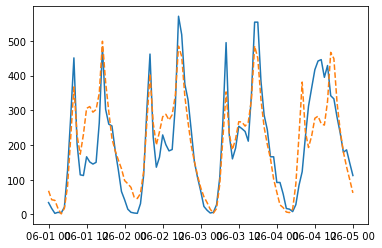

In [59]:
plot_timerange(reg, '2011-06-01', '2011-06-05')

Often we are interested in a single score. The default score method for regression problems is the [r2_score](https://en.wikipedia.org/wiki/Coefficient_of_determination).

In [60]:
train_score = reg.score(X_train, y_train)
### TODO calculate test score (the score on X_test, ~ 1 line of code)
test_score = reg.score(X_test, y_test)

print('train score', train_score)
print('test score', test_score)

train score 0.6813958127305259
test score 0.6820591407880712


### 3.3  Save and load the trained model
We can pickle any cuML model

In [61]:
import pickle
pickle_file = 'my_model.pickle'

with open(pickle_file, 'wb') as pf:
    pickle.dump(reg, pf)

Load the saved model

In [62]:
with open(pickle_file, 'rb') as pf:
        loaded_model = pickle.load(pf)

print('Loaded model   score', loaded_model.score(X_test, y_test))
print('Original model score', reg.score(X_test, y_test))

Loaded model   score 0.6820591407880712
Original model score 0.6820591407880712


### 3.4 Ridge regression with hyperparameter tuning
Ridge regression is a linear regression model with an added L2 regularization term. Regularization is often used in practice to avoid overfitting. The strength of the regularization is set by the alpha hyperparameter. 
We're going to do a small hyperparameter search for alpha, checking 100 different values. This is fast to do with RAPIDS. Also notice that we are appending the results of each Ridge model onto the dictionary containing our earlier results, so we can more easily see which model is the best at the end. 

In [63]:
output = {'score_OLS': test_score}

for alpha in np.arange(0.01, 1, 0.01): #alpha value has to be positive    
    ridge = cuml.Ridge(alpha=alpha, fit_intercept=True)
    ### TODO fit the model and calculate the test score (2 lines of code)
    ridge.fit(X_train, y_train)
    score = ridge.score(X_test, y_test)
    ### END EXCERCISE ###
    output['score_RIDGE_{}'.format(alpha)] = score

Here we see that our regulaized model does better than the rest, include OLS with all the variables. 

In [64]:
print('Max score: {}'.format(max(output, key=output.get)))

Max score: score_RIDGE_0.33


### 3.5 Additional cuML models (Optional)
#### 3.5.1 Support vector regression

Support vector regression is a more complex model, with an execution time that scales with at least O(n_rows^2). RAPIDS cuML includes a fast SVM solver that makes it feasable to run SVM on larger datasets.

In [65]:
%%time
reg = cuml.svm.SVR(kernel='rbf', gamma=0.1, C=100, epsilon=0.1)
## Todo
reg.fit(X_train, y_train)
reg.score(X_train, y_train)
reg.score(X_test, y_test)

CPU times: user 276 ms, sys: 160 ms, total: 437 ms
Wall time: 436 ms


0.8799074097909845

We can also use sklearns [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to perform hyperparameter search. Sklearn's GridSearchCV requires input that the input data is a host array. Fortunately cuML is flexible with the [input format](https://medium.com/rapids-ai/input-and-output-configurability-in-rapids-cuml-e719d72c135b), and we can pass numpy array directly to it (at a cost of additional host to device copies, because under the hood cuML copies the data to the GPU). If the data size is reasonably small, then we can pay the price of additional data movement and  combine the convenience of GridSearchCV with the speed of cuML algorithms.

In [66]:
param_grid = [ {'C': [0.01, 0.1, 1, 10, 100], 'gamma': [10, 1, 0.1, 0.01, 0.001], 'kernel': ['rbf']} ]

In [67]:
X_train_np = X_train.as_matrix()
y_train_np = y_train.to_array()
X_test_np = X_test.as_matrix() 
y_test_np = y_test.to_array()

In [68]:
from sklearn.model_selection import GridSearchCV
reg = GridSearchCV(cuml.svm.SVR(), param_grid, scoring='r2' )

reg.fit(X_train_np, y_train_np)

print("Best parameters set found on development set:")
print()
print(reg.best_params_)
print()
print("Grid scores on development set:")
print()
means = reg.cv_results_['mean_test_score']
stds = reg.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, reg.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

Best parameters set found on development set:

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

Grid scores on development set:

-0.067 (+/-0.011) for {'C': 0.01, 'gamma': 10, 'kernel': 'rbf'}
-0.066 (+/-0.011) for {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}
-0.061 (+/-0.011) for {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
-0.066 (+/-0.011) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
-0.067 (+/-0.011) for {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
-0.067 (+/-0.011) for {'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}
-0.060 (+/-0.011) for {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
-0.012 (+/-0.011) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
-0.057 (+/-0.011) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
-0.066 (+/-0.011) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
-0.063 (+/-0.011) for {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
0.001 (+/-0.011) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.273 (+/-0.014) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.023 (+/-0.009) for {'C': 1, 'gamma': 0.01, 'kerne

#### 3.5.2 KNN Regression
k-Nearest Neighbors regression is a machine learning technique that predicts an unknown observation by using the k most similar known observations in the training dataset.

In [69]:
%%time
### TODO tune the n_neighbors hyperparameter to achieve better performance
knn = cuml.neighbors.KNeighborsRegressor(n_neighbors=8)
knn.fit(X_train, y_train, convert_dtype=True)
pred = knn.predict(X_test)
knn.score(X_test, y_test)

CPU times: user 60.3 ms, sys: 261 ms, total: 321 ms
Wall time: 320 ms


0.7120309195645623

We can compare the execution time of training KNN with cuML and with scikit-learn

In [70]:
import sklearn
import sklearn.neighbors

In [71]:
%%time
knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=8)
knn.fit(X_train_np, y_train_np,)
pred = knn.predict(X_test_np)
knn.score(X_test_np, y_test_np)

CPU times: user 5.83 s, sys: 0 ns, total: 5.83 s
Wall time: 5.83 s


0.7119398662494515

### 3.6 XGBoost (Optional)
RAPIDS integrates seamlessly with the XGBoost library. Here is how to use it for our example

In [72]:
import xgboost as xgb

In [73]:
xgr=xgb.XGBRegressor(max_depth=8,min_child_weight=6,gamma=0.4)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [74]:
# instantiate params
params = {}

# general params
general_params = {}
params.update(general_params)

# booster params
booster_params = {'tree_method': 'gpu_hist'}
params.update(booster_params)

# learning task params
learning_task_params = {'objective': 'reg:squarederror'}
params.update(learning_task_params)
print(params)

{'tree_method': 'gpu_hist', 'objective': 'reg:squarederror'}


In [75]:
evallist = [(dtest, 'test'), (dtrain, 'train')]
num_round = 100

In [76]:
bst = xgb.train(params, dtrain, num_round, evallist)


[0]	test-rmse:199.18784	train-rmse:200.30351
[1]	test-rmse:162.09444	train-rmse:162.71335
[2]	test-rmse:137.25905	train-rmse:136.83050
[3]	test-rmse:120.35908	train-rmse:119.77563
[4]	test-rmse:107.99054	train-rmse:107.15930
[5]	test-rmse:100.17688	train-rmse:99.31792
[6]	test-rmse:94.51825	train-rmse:93.23972
[7]	test-rmse:90.02152	train-rmse:88.41567
[8]	test-rmse:87.24374	train-rmse:85.44088
[9]	test-rmse:84.38741	train-rmse:82.57428
[10]	test-rmse:81.15561	train-rmse:78.72398
[11]	test-rmse:78.11271	train-rmse:74.94260
[12]	test-rmse:76.49943	train-rmse:72.95665
[13]	test-rmse:74.66074	train-rmse:70.91374
[14]	test-rmse:72.05053	train-rmse:67.98150
[15]	test-rmse:70.95134	train-rmse:66.81727
[16]	test-rmse:70.03428	train-rmse:65.69633
[17]	test-rmse:67.92854	train-rmse:63.02364
[18]	test-rmse:67.05556	train-rmse:61.93159
[19]	test-rmse:65.70933	train-rmse:60.53908
[20]	test-rmse:65.15248	train-rmse:59.73316
[21]	test-rmse:64.53308	train-rmse:58.98966
[22]	test-rmse:63.51178	train-r

In [77]:
y_pred = bst.predict(dtest)

In [78]:
import cupy as cp
from cuml.metrics.regression import r2_score
y_pred_cp = cp.asarray(y_pred)
y_test_cp = cp.asarray(y_test).astype(np.float32)

In [79]:
r2_score(y_test_cp, y_pred_cp)

0.9151233434677124

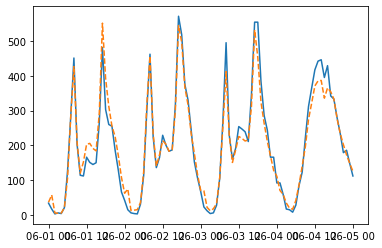

In [80]:
plot_timerange(reg, '2011-06-01', '2011-06-05')

## Licensing
  
This material is released by NVIDIA Corporation under the Creative Commons Attribution 4.0 International (CC BY 4.0).

[Previous Notebook](Challenge.ipynb)
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
[1](Challenge.ipynb)
[2]
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;


&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&ensp;
[Home Page](../../START_HERE.ipynb)